In [206]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,precision_recall_curve,auc,roc_auc_score,recall_score,classification_report

### Air Pressure System Failures in Scania Trucks

The task in this dataset is to predict failures and minimize costs based on sensor readings. The training set contains 60000 examples in total in which 59000 belong to the negative class and 1000 positive class. The test set contains 16000 examples. There are 171 attributes per record.

To solve this problem, this notebook is organized as follows:
* Data analysis: check the atributes values, handle missing data (if any), outliers and correlation matrix
* PCA: since the dataset has 171 atributes, we are going to choose the more important ones for classification
* Classification: we are going to check performance of LR, RF, SVM, Random Forest and XGBoost

#### Step 1 - Data analysis

1. Data description

The data has 170 atributes and one target class. The class has categorical values (neg and pos). When reading the dataset and analysing the first 5 rows, we can see that there are already missing values on some atributes. Hence, I checked where there are NA values and fill them with data mean. When doing that, we can see that, except atribute aa_000, all the atributes have null values. 

2. Data statistics

Also, when seeing the data statistics description, there significative difference between min-max values in some atributes like eg_000 (min = 0 and max = 1146), and aa_000 (min = 0 and max = 2.746564e+06). Hence, it is important to normalize values before training. With data description, we can also see the presence of possible outliers. For instance, atribute ad_000 has a maximum value wich represents the double of the std value. We can confirm that by ploting a boxplot of some atributes.

In the same fashion, if we visualize the boxplot of the last two atributes (ef_000 and eg_000), we can see the presence of possible outliers.

3. Correlation Matrix

Lastly, we can plot a correlation matrix to see if there are correlate atributes. In this matrix, values closer to 1 are highly correlated.  

#### Read dataset and check the first 5 rows

In [181]:
data = pd.read_csv("data/aps_failure_training_set.csv", na_values="na")
data.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


#### Checking missing data


In [182]:
data.isnull().any()

class     False
aa_000    False
ab_000     True
ac_000     True
ad_000     True
          ...  
ee_007     True
ee_008     True
ee_009     True
ef_000     True
eg_000     True
Length: 171, dtype: bool

#### Filling NA values with the data mean


In [183]:
data= data.fillna(data.mean()).dropna(axis =1 , how ='all')

#### See data after dealing with missing values


In [184]:
data.isnull().any()

class     False
aa_000    False
ab_000    False
ac_000    False
ad_000    False
          ...  
ee_007    False
ee_008    False
ee_009    False
ef_000    False
eg_000    False
Length: 171, dtype: bool

#### Data normalization

In [185]:
X = data.iloc[:,data.columns != 'class']
Y = data['class']

In [186]:
scaler = StandardScaler()

scaler.fit(X)

X = scaler.transform(X)

#### Statistics description of the data


In [187]:
data.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,60000.000000,6.000000e+04,6.000000e+04,60000.000000,60000.000000,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,...,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,60000.000000,60000.000000
mean,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,...,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,1.454301e+05,1.660588,7.724678e+08,3.504515e+07,158.142022,205.375337,2.036363e+04,3.400875e+04,1.494791e+05,7.574598e+05,...,1.149060e+06,5.402722e+05,1.161763e+06,1.114758e+06,1.063164e+06,1.718366e+06,4.469894e+05,4.720424e+04,4.268529,8.627929
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.340000e+02,0.713189,2.000000e+01,4.200000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,3.033500e+03,1.204000e+03,2.848500e+03,3.839000e+03,5.600000e+02,1.180000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.077600e+04,0.713189,1.880000e+02,2.880000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.397270e+05,1.148530e+05,2.283220e+05,1.960600e+05,9.976600e+04,4.358700e+04,4.474000e+03,0.000000e+00,0.000000,0.000000
75%,4.866800e+04,0.713189,1.686000e+03,8.426500e+03,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,4.454897e+05,2.164440e+05,4.624655e+05,4.003010e+05,2.833455e+05,1.732245e+05,1.387300e+05,2.366000e+03,0.000000,0.000000
max,2.746564e+06,204.000000,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,6.340207e+07,...,7.793393e+07,3.775839e+07,9.715238e+07,5.743524e+07,3.160781e+07,1.195801e+08,1.926740e+07,3.810078e+06,482.000000,1146.000000


#### Boxplot

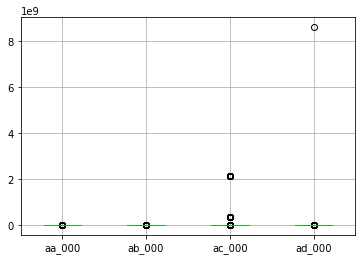

In [188]:
data.iloc[:,:5].boxplot() ### first 5 atributes

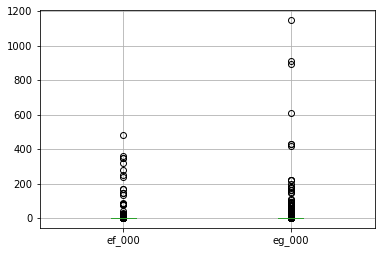

In [189]:
data.iloc[:,-2:].boxplot() ### Last 2 atributes

#### Correlation Matrix

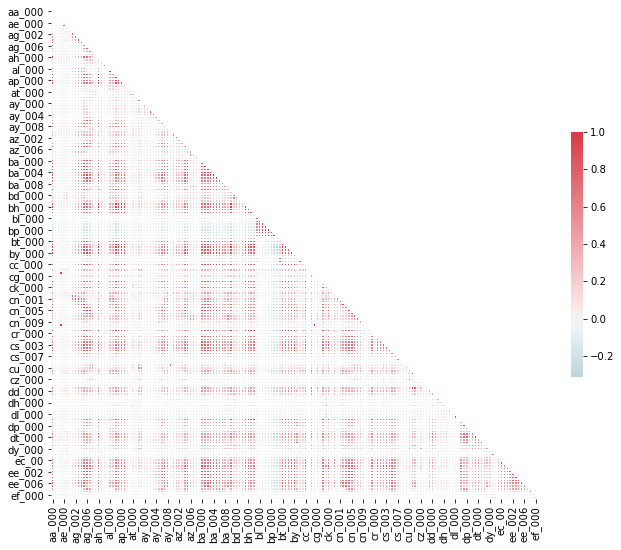

In [190]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Class frequency

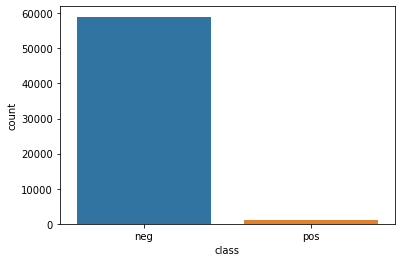

In [191]:
ax = sns.countplot(x="class", data=data)

#### Step 2 - PCA

As we have a lot of possible correlated atributes, we can apply a PCA to return the most important ones. By using a PCA with 95% of data variance, we reduced the number of atributes to 82. 

In [192]:
pca = PCA(0.95)

pca.fit(X)

pca.n_components_


82

In [193]:
X_ = pca.transform(X)

df_X= pd.DataFrame(X_)


In [194]:
df_X

,0,1,2,3,4,5,6,7,8,9,...,72,73,74,75,76,77,78,79,80,81
0,2.407533,-1.275187,-1.550152,0.980419,-0.083018,0.754907,-0.471116,-0.001142,-0.185602,-1.329810,...,-0.299811,0.189246,-0.115952,-0.649872,-0.098207,0.501070,0.461358,0.106849,-0.152670,-0.111830
1,-0.610388,-0.481413,0.008950,0.121946,-0.123178,0.102725,-0.184513,-0.000054,0.011270,0.100001,...,-0.281064,-0.229433,0.043047,0.208372,-0.054231,-0.270740,-0.495809,0.040098,0.270760,-0.514386
2,-1.252347,-0.127711,-0.355506,-0.585498,0.148654,0.111663,0.091791,-0.018631,-0.094904,0.198062,...,0.009446,0.063616,0.075767,-0.021353,-0.056342,0.008052,0.084104,0.085170,0.005156,0.060981
3,-3.255259,0.228883,0.348423,-0.582976,0.387481,-0.280264,0.299342,-0.022313,0.533324,1.115999,...,0.095799,0.216185,-0.095563,-0.075910,0.089047,-0.291497,0.014230,-0.071984,-0.215797,0.048647
4,0.285086,-0.150595,-0.747294,0.300815,-0.588138,0.319878,-0.141804,0.006020,-0.413576,-1.152549,...,-0.288888,0.025726,0.388666,-0.376435,0.079918,0.014274,0.147027,-0.193611,-0.226973,0.290897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,5.118700,-1.390744,-3.591526,-0.643308,-0.682376,0.814888,-0.799735,0.024634,-0.904494,-1.345411,...,-0.407423,-0.034555,0.419497,-0.097266,0.072958,-0.363291,-0.396520,0.036579,0.352082,-0.276891
59996,-3.126308,0.136270,0.178339,-0.613330,0.437261,-0.206002,0.198643,-0.023060,0.384521,0.623354,...,0.266534,0.017691,-0.045460,0.106889,-0.046130,-0.108442,-0.087508,0.006577,0.069379,0.074538
59997,-3.250731,0.128958,0.256914,-0.693550,0.485970,-0.258481,0.245068,-0.026687,0.467216,0.890471,...,0.293456,0.002354,-0.030673,0.080895,-0.064020,-0.085615,-0.061388,0.018981,0.054486,0.123076
59998,2.403234,-2.673268,-1.736793,1.006774,-0.120246,1.247779,-1.650527,-0.030212,0.077628,0.202400,...,-0.101091,0.556293,-0.026484,-0.680505,1.087159,0.473058,0.425954,-0.258588,-0.651007,0.250924


### Classification

In [195]:
from imblearn.under_sampling import RandomUnderSampler

Y = Y.map({'neg':0, 'pos':1})
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X, Y)

In [196]:
print(X.shape)
print(X_rus.shape)

(60000, 170)
(2000, 170)


In [197]:
print("Percentage Neg: " , len(Y[Y == 0])/len(Y))
print("Percentage Pos: ", len(Y[Y  == 1])/len(Y))

Percentage Neg:  0.9833333333333333
Percentage Pos:  0.016666666666666666


In [198]:
print("Percentage Neg: " , len(y_rus[y_rus == 0])/len(y_rus))
print("Percentage Pos: ", len(y_rus[y_rus  == 1])/len(y_rus))

Percentage Neg:  0.5
Percentage Pos:  0.5


In [200]:
X_train,X_val,Y_train,Y_val = train_test_split(X_rus, y_rus, stratify = y_rus, test_size = 0.2,random_state = 0)

In [201]:
print('Number of instances for training and validation:')
print(X_train.shape)
print(X_val.shape)

Number of instances for training and validation:
(1600, 170)
(400, 170)


In [179]:
print("Percentage Neg in validation: " , len(Y_val[Y_val == 'neg'])/len(Y_val))
print("Percentage Pos in validation: ", len(Y_val[Y_val == 'pos'])/len(Y_val))

Percentage Neg in validation:  0.0
Percentage Pos in validation:  0.0


In [207]:
lr = LogisticRegression(C = 0.0001, penalty = 'l2')
lr.fit(X_train,Y_train)
y_pred = lr.predict(X_val)

In [209]:
print(classification_report(Y_val,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       200
           1       0.96      0.83      0.89       200

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



In [ ]:
confusion_matrix(Y,y_pred)